# <div align="center">Aim of the code</div>

1) To the XRD data from a .cif file and stores it in a .csv file. This code automate the process for multple cif files
2) To generate the data for neural network, X_train and Y_train. X_train will contain all the intensity values (scaled between 0 and 1) and Y_train will contain the corresponding lattice parameters (a, b,c, alpha, beta, gamma).
3) Train a neural network

## Note:

We will train our model only for P-1 space group

# Libraries

In [8]:
import numpy as np

import os

# import the library for manimulating cif data
import Dans_Diffraction as dif


# Create a function to generate the X_train and Y_train data for machine learning

In [9]:

def generate_data_set(file_paths):
    
    # define relevant parameters
    energy_kev = dif.fc.wave2energy(1.54059)

    count = 0

    # Enter for loop
    for files in file_paths:

        xtl = dif.Crystal(files);         # ; suppresses the output a given line of code
        
        # get the lattice parameters, a,b,c, and alpha, beta, gamma
        lattice_parameters = xtl.Cell.lp();

        # get the 2theta, corresponding intensities, and reflections (h,k, l values (Miler indices)

        xtl.Scatter.setup_scatter(energy_kev=energy_kev, min_twotheta=5, max_twotheta=100, scattering_type='xray', powder_units='tth');
        twotheta, intensity, reflections = xtl.Scatter.powder(units='tth', peak_width=0.01, background=0);

        # since we don't need the reflections and twotheta we can delete it from memory to save RAM
        del(twotheta, reflections)
        
        # scale the intensity between 0 and 1
        intensity /= np.max(intensity);
        
        
        # We don't need all of the points so we will skip some of the 2theta values
        intensity = intensity[0:intensity.size:10]

        if count == 0:
            # Create an empty numpy array to store X_train
            X_train = np.empty((len(file_paths), intensity.size));

            # Create an empty numpy array to store Y_train
            Y_train = np.empty((len(file_paths), len(lattice_parameters)));


        # create X_train containing intensity values for all two theta along a row.
        X_train[count] = intensity;
        Y_train[count] = np.array(lattice_parameters);


        count += 1        # this simply means count = count + 1
    
    del(intensity)        # delete the intensity matrix at the end to clear up RAM
    
    return X_train, Y_train


# Create the X and Y training data

In [10]:
X_train = np.genfromtxt('./training_data/cleaned_training_data/X_train.csv', delimiter=',')

Y_train = np.genfromtxt('./training_data/cleaned_training_data/Y_train.csv', delimiter=',')


In [11]:
print(X_train.shape, Y_train.shape)

(792, 1179) (792, 6)


# Scale Y_train from 0 to 1, X_train is already scaled

In [12]:
a_max = np.max(Y_train[:,0])         # maximum of a
b_max = np.max(Y_train[:,1])         # maximum of b
c_max = np.max(Y_train[:,2])         # maximum of c

alpha_max = np.max(Y_train[:,3])     # maximum of alpha
beta_max  = np.max(Y_train[:,4])     # maximum of beta
gamma_max = np.max(Y_train[:,5])     # maximum of gamma


Y_train[:,0] *= 1/a_max;             # this means mutiplication of 0th column with 1/a_max

Y_train[:,1] *= 1/b_max;

Y_train[:,2] *= 1/c_max;

Y_train[:,3] *= 1/alpha_max;
Y_train[:,4] *= 1/beta_max;
Y_train[:,5] *= 1/gamma_max;


# Take last 5 rows out of the training data for testing the model

In [13]:
X_test = X_train[X_train[:,0].size - 5: X_train[:,0].size, :]
Y_test = Y_train[Y_train[:,0].size - 5: Y_train[:,0].size, :]

print(X_test.shape, Y_test.shape)

(5, 1179) (5, 6)


# Delete last 5 rows from the X_train and Y_train

In [14]:
X_train = np.delete(X_train, np.arange(X_train[:,0].size-5,X_train[:,0].size, 1), axis=0);
Y_train = np.delete(Y_train, np.arange(Y_train[:,0].size-5,Y_train[:,0].size, 1), axis=0);

print(X_train.shape, Y_train.shape)

(787, 1179) (787, 6)


# Check if data is correctly generated

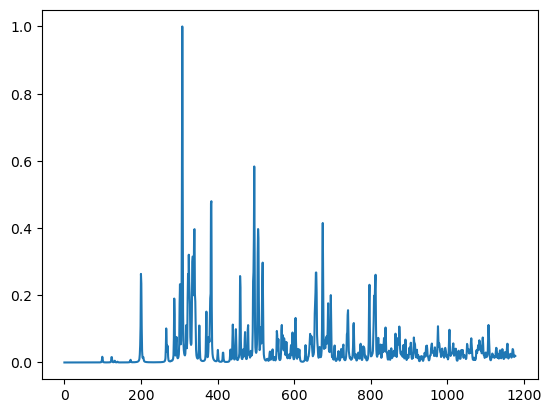

In [15]:
import matplotlib.pyplot as plt

plt.plot(X_train[16])

# Create your multiple output MLP model

In [16]:
# Libraries
from keras.models import Sequential
from keras.layers import Dense

# get the model
def get_model(n_inputs, n_outputs):
    
    # Define your Keras model here
    model = Sequential()

    # The Input Layer :
    model.add(Dense(1024, kernel_initializer='normal', bias_initializer='normal', input_dim = n_inputs, activation='relu'))

    # The Hidden Layers :
    model.add(Dense(1024, kernel_initializer='normal',bias_initializer='normal', activation='relu'))
    model.add(Dense(512, kernel_initializer='normal',bias_initializer='normal', activation='relu'))
    model.add(Dense(512, kernel_initializer='normal',bias_initializer='normal', activation='relu'))

    # The Output Layer :
    model.add(Dense(n_outputs, kernel_initializer='normal',bias_initializer='normal', activation='sigmoid'))
  

    # Compile the network :
#    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])

#    model.compile(loss='mae', optimizer='adam')
    return model

# Train the model

In [17]:
n_inputs, n_outputs = X_train[0].size, Y_train[0].size

# get model
model = get_model(n_inputs, n_outputs)

# fit the model on all data
model.fit(X_train, Y_train, epochs=200,verbose = 1)


Epoch 1/200
25/25 [==============================] - 2s 30ms/step - loss: 0.0891 - accuracy: 0.4003
Epoch 2/200
25/25 [==============================] - 1s 30ms/step - loss: 0.0482 - accuracy: 0.5172
Epoch 3/200
25/25 [==============================] - 1s 30ms/step - loss: 0.0388 - accuracy: 0.5515
Epoch 4/200
25/25 [==============================] - 1s 30ms/step - loss: 0.0310 - accuracy: 0.6061
Epoch 5/200
25/25 [==============================] - 1s 30ms/step - loss: 0.0289 - accuracy: 0.6823
Epoch 6/200
25/25 [==============================] - 1s 34ms/step - loss: 0.0265 - accuracy: 0.6163
Epoch 7/200
25/25 [==============================] - 1s 33ms/step - loss: 0.0227 - accuracy: 0.7637
Epoch 8/200
25/25 [==============================] - 1s 31ms/step - loss: 0.0242 - accuracy: 0.8081
Epoch 9/200
25/25 [==============================] - 1s 31ms/step - loss: 0.0205 - accuracy: 0.7929
Epoch 10/200
25/25 [==============================] - 1s 31ms/step - loss: 0.0189 - accuracy: 0.7662

# Make prediction

In [18]:
# Create an empty list to store the paths of all .cif files
file_paths = []

training_data_directory = './training_data/cif_files/P6_slash_mmm/'             # ./ means current directory

for file in os.listdir(training_data_directory):
    if ".cif" in file:
        file_paths.append('./training_data/cif_files/P6_slash_mmm/' + file)

In [19]:
%%capture

# The above line of code supresses the output of this entire cell
X_test, Y_test = generate_data_set(file_paths[0:8]);    

In [20]:
X_test

array([[5.64023805e-06, 5.66636993e-06, 5.69269493e-06, ...,
        6.65966215e-05, 6.40359710e-05, 6.15009599e-05],
       [2.84571031e-06, 2.85824178e-06, 2.87085950e-06, ...,
        1.48534102e-03, 8.27928304e-04, 5.37969251e-04],
       [3.71947210e-05, 3.76433187e-05, 3.81012974e-05, ...,
        1.08607776e-03, 9.12174382e-04, 7.81732281e-04],
       ...,
       [6.65364789e-06, 6.68790029e-06, 6.72243789e-06, ...,
        2.44682236e-04, 2.17715108e-04, 1.95606192e-04],
       [1.49428422e-05, 1.51333889e-05, 1.53297330e-05, ...,
        1.58486801e-01, 1.18073481e-01, 3.35719279e-02],
       [1.43660778e-05, 1.45455504e-05, 1.47304312e-05, ...,
        1.62587508e-01, 9.21169868e-02, 2.46362460e-02]])

In [21]:
from numpy import asarray

# for i in range(Y_test[:,0].size):
#     X    = asarray([X_test[i]])
#     yhat = model.predict(X)
#     y    = asarray([Y_test[i]])


    
for x, y in zip(X_test, Y_test):
    X    = asarray([x])
    Yhat = model.predict(X)
    Y    = asarray([y])
        

    Yhat[0,0] *=a_max;
    Yhat[0,1] *=b_max;
    Yhat[0,2] *=c_max;
    Yhat[0,3] *=alpha_max;
    Yhat[0,4] *=beta_max;
    Yhat[0,5] *=gamma_max;
    
#     Y[0,0] *=a_max;
#     Y[0,1] *=b_max;
#     Y[0,2] *=c_max;
#     Y[0,3] *=alpha_max;
#     Y[0,4] *=beta_max;
#     Y[0,5] *=gamma_max;
    

    print(' Predicted         : %s' % Yhat[0][0:3])
    print(' Actual            : %s' % Y[0][0:3])
    print(' percentage errors : %s' % np.abs(np.divide((Y[0][0:3] - Yhat[0][0:3])*100,Y[0][0:3])))
    print(" ")

1/1 [==============================] - 0s 174ms/step
 Predicted         : [4.9954076 4.8941383 3.955645 ]
 Actual            : [5.0125 5.0125 3.9873]
 percentage errors : [0.34099588 2.36132995 0.7938935 ]
 
1/1 [==============================] - 0s 34ms/step
 Predicted         : [4.6835723 4.6033554 3.9656978]
 Actual            : [3.085 3.085 3.523]
 percentage errors : [51.81757836 49.21735519 12.56593146]
 
1/1 [==============================] - 0s 28ms/step
 Predicted         : [7.0600166 6.792942  6.6204114]
 Actual            : [7.298 7.298 3.899]
 percentage errors : [ 3.26093954  6.92049812 69.79767623]
 
1/1 [==============================] - 0s 29ms/step
 Predicted         : [4.4351153 4.3164244 3.8949432]
 Actual            : [4.335 4.335 4.226]
 percentage errors : [2.30946568 0.42850358 7.83380887]
 
1/1 [==============================] - 0s 28ms/step
 Predicted         : [3.5387833 3.5012405 3.589822 ]
 Actual            : [8.104 8.104 4.197]
 percentage errors : [56.332

# Note:
Python is case sensitive i.e., two variables named "a" and "A" are considered different variables